In [1]:

import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import os

iTrainDay = 5
modulePath = './p77111126_model'

def norm(v):
      tva = [ (x - np.min(x)) / (np.max(x) - np.min(x)) for x in v]
      return np.array(tva)

def norm_max_min(v):
      v_max = np.max(v)
      v_min = np.min(v)
      tva = [ (x - np.min(x)) / (np.max(x) - np.min(x)) for x in v]
      return np.array(tva) , v_max , v_min

def de_norm(tva , v_max , v_min):
      v_x = [ y*(v_max-v_min) + v_min for y in tva]
      return np.array(v_x)

def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

def train_windows(df, ref_day=3, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        # print(df.iloc[i])
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]))
    return np.array(X_train), np.array(Y_train)

def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='linear'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

def Train(sTrainCSV = './training_data.csv' , sSaveModulePath = 'D:\\LSTM\\my_model'):
        train = pd.read_csv(sTrainCSV)
        train.head()
        train = train.dropna()
        train.iloc[:,0:4] = normalize(train.iloc[:,0:4])
        X_train, Y_train = train_windows(train, iTrainDay, 1)
        model = lstm_stock_model(X_train.shape)
        callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")
        history = model.fit(X_train, Y_train, epochs=1000, batch_size=5, validation_split=0.1, callbacks=[callback],shuffle=True)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        model.save(sSaveModulePath)

def LoadModule(sModulePath = 'D:\\LSTM\\my_model'): 
    model = keras.models.load_model(sModulePath)
    print('read module !!')
    
def PredictCSV(sInputCSV = './testing_data.csv' , sOutputCSV = 'output.csv'):
    #Testing Datas Preparee
    print("Reading Testing data from " , sInputCSV)
    pd_csv_test_file  = pd.read_csv(sInputCSV)
    np_csv_test_file = pd_csv_test_file.to_numpy()
    print('TestData(Days) : ' , np_csv_test_file[:,0:3].shape[0])
    iMyStockCount = 0 #庫存數量
    trade_mode = 0 #1買進、0持平、-1放空
    trade_mode_record = np.empty([np_csv_test_file[:,0:3].shape[0]]) 
    
    for i in range(np_csv_test_file[:,0:3].shape[0]):
        if(i < iTrainDay):
            np_inputs = np.zeros((1,iTrainDay,3)) #前五天不交易
        else:
            np_inputs = np_csv_test_file[i-iTrainDay:i,0:3][:,np.newaxis] #拿前五天的資料來預測
            
        testing_data , v_max , v_min = norm_max_min(np_inputs)
        predict_result = model.predict(testing_data)
        
        predict_price = de_norm(predict_result , v_max , v_min)[0][0] #預測股價
        #print('第' , i , '次預測股價 =>' , de_norm(predict_result , v_max , v_min)[0][0])
        current_price = np_csv_test_file[i,3] #現在股價(收盤價)
        
        diff_value = predict_price - current_price
        trade_keyword = 'No Trade'
        if(diff_value > 0): #只做多
            if(iMyStockCount <= 0):
                trade_mode = 1
                trade_keyword = 'Buy'
            else:
                trade_mode = 0
                trade_keyword = 'No Trade'
            #print('No.' , i , ' predict stock price =>' , predict_price)
        else:
            
            if(iMyStockCount > 0):
                trade_mode = -1
                trade_keyword = 'sell'
            else:
                trade_mode = 0
                trade_keyword = 'No Trade'
                
        trade_mode_record[i] = trade_mode
        iMyStockCount = iMyStockCount + trade_mode
        print(i , '-' , 'current Price:' ,current_price , ' Predict Price : ' ,  predict_price ,'  This trade rule is : ' , trade_keyword , ' Inventory : ' , iMyStockCount)
    #print(trade_mode_record)
    
    
    print('Save csv file...RorCount : ' , trade_mode_record.shape[0])
    # convert array into dataframe
    DF = pd.DataFrame(trade_mode_record)

    # save the dataframe as a csv file
    DF.to_csv(sOutputCSV , index = False)

    print('Save csv file...Done!!...' , sOutputCSV)


    

In [ ]:
#Testing Datas
#pd_csv_test_file  = pd.read_csv('./testing_data.csv')
#np_csv_test_file = pd_csv_test_file.to_numpy()

#print('原始資料維度:' , np_csv_test_file.ndim)
#print('原始資料行數&列數' , np_csv_test_file.shape)
#print('宣告一個預測用的矩陣')
#np_inputs = np.zeros((1,5,3))
#print(np_inputs)
                     
#for i in range(np_csv_test_file[:,0:3].shape[0]):
#    if(i < 5):
#        np_inputs = np.zeros((1,5,3))
#    else:
#        np_inputs = np_csv_test_file[0:5,0:3][:,np.newaxis]
#    print(np_inputs)
#    print('===')

#print(np_csv_test_file[0:5,0:3])
#print('------')
#row_window = np_csv_test_file[ : , 2 ]
#print(row_window)
#print(np_csv_test_file.size)
#for i_row in range( 4 ):
##for i_row in range( np_csv_test_file.shape[0] ):
#    print(np_csv_test_file[i_row])
#    #row_window = np.vstack(row_window , np_csv_test_file[i_row])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 256)            266240    
                                                                 
 lstm_1 (LSTM)               (None, 5, 256)            525312    
                                                                 
 time_distributed (TimeDistr  (None, 5, 1)             257       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                        

INFO:tensorflow:Assets written to: D:\LSTM\my_model\assets


INFO:tensorflow:Assets written to: D:\LSTM\my_model\assets


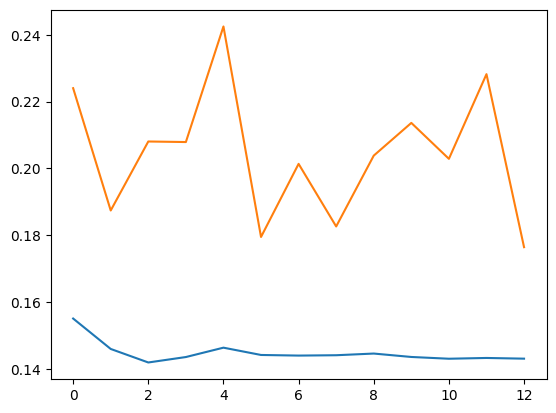

In [3]:

b_train = True
#if b_train == True:
    #Train('./training_data.csv' , modulePath)
    #train = pd.read_csv('./training_data.csv')
    #train.head()
    ###test = pd.read_csv('./testing_data.csv')
    ###test.head()
    #train = train.dropna()
    #train.iloc[:,0:4] = normalize(train.iloc[:,0:4])
    ###test.iloc[:,0:4] = normalize(test.iloc[:,0:4])
    #X_train, Y_train = train_windows(train, iTrainDay, 1)
    ###X_test, Y_test = train_windows(test, iTrainDay, 1)


if b_train == True:
    #model = lstm_stock_model(X_train.shape)
    #callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")
    #history = model.fit(X_train, Y_train, epochs=1000, batch_size=5, validation_split=0.1, callbacks=[callback],shuffle=True)
    #plt.plot(history.history['loss'], label='train')
    #plt.plot(history.history['val_loss'], label='test')
    #model.save("D:\\LSTM\\my_model")
    Train('./training_data.csv' , modulePath)
else:
    LoadModule(modulePath)
    #model = keras.models.load_model('D:\\LSTM\\my_model')
    #print('read module !!')
    

In [ ]:
PredictCSV('./testing_data.csv' , 'output.csv')

In [ ]:

    #Testing Datas Preparee
    pd_csv_test_file  = pd.read_csv('./testing_data.csv')
    np_csv_test_file = pd_csv_test_file.to_numpy()
    print('TestData(Days) : ' , np_csv_test_file[:,0:3].shape[0])
    iMyStockCount = 0 #庫存數量
    trade_mode = 0 #1買進、0持平、-1放空
    trade_mode_record = np.empty([np_csv_test_file[:,0:3].shape[0]]) 
    
    for i in range(np_csv_test_file[:,0:3].shape[0]):
        if(i < iTrainDay):
            np_inputs = np.zeros((1,iTrainDay,3)) #前五天不交易
        else:
            np_inputs = np_csv_test_file[i-iTrainDay:i,0:3][:,np.newaxis] #拿前五天的資料來預測
            
        testing_data , v_max , v_min = norm_max_min(np_inputs)
        predict_result = model.predict(testing_data)
        
        predict_price = de_norm(predict_result , v_max , v_min)[0][0] #預測股價
        #print('第' , i , '次預測股價 =>' , de_norm(predict_result , v_max , v_min)[0][0])
        current_price = np_csv_test_file[i,3] #現在股價(收盤價)
        
        diff_value = predict_price - current_price
        trade_keyword = 'No Trade'
        if(diff_value > 0): #只做多
            if(iMyStockCount <= 0):
                trade_mode = 1
                trade_keyword = 'Buy'
            else:
                trade_mode = 0
                trade_keyword = 'No Trade'
            print('No.' , i , ' predict stock price =>' , predict_price)
        else:
            
            if(iMyStockCount > 0):
                trade_mode = -1
                trade_keyword = 'sell'
            else:
                trade_mode = 0
                trade_keyword = 'No Trade'
                
        trade_mode_record[i] = trade_mode
        iMyStockCount = iMyStockCount + trade_mode
        print('This trade rule is : ' , trade_keyword , ' Inventory : ' , iMyStockCount)
    print(trade_mode_record)

In [ ]:

print('Save csv file...RorCount : ' , trade_mode_record.shape[0])
# convert array into dataframe
DF = pd.DataFrame(trade_mode_record)
 
# save the dataframe as a csv file
DF.to_csv("output.csv" , index = False)

print('Save csv file...Done!!')